# *Merged Jupyter Notebook*

<hr><font color="green"><h1>from file: 1</h1></font>

<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/main/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-Project 2: Optimization and Text Classification**

## **Project Setup**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

In [7]:
#%cd /content/drive/MyDrive/git/COMP551/projects/p2
%cd /content/drive/MyDrive/Git/COMP551/projects/p2

/content/drive/MyDrive/Git/COMP551/projects/p2


In [22]:
import pandas as pd
import numpy as np
import time
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1234)

## **PART I: Optimaztion**

### **Import Data**

In [9]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

In [10]:
print('Train set size: ' + str(train_df.shape[0]))
print('Validation set size: ' + str(val_df.shape[0]))
print('Test set size: ' + str(test_df.shape[0]))

total_dataset_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
print('Total dataset size: ' + str(total_dataset_size))

# Percentage of positive diabetes diagnostic in train set is 35.5%
train_df['Outcome'].value_counts(normalize=True)


Train set size: 600
Validation set size: 100
Test set size: 68
Total dataset size: 768


0    0.645
1    0.355
Name: Outcome, dtype: float64

### **1. Logisitic regression, learning rate and number of training iterations**
You should first start by running the logistic regression code using the given implementation. This will serve as a baseline for the following steps. Find a learning rate and a number of training iterations such that the model has fully converged to a solution. Make sure to provide empirical evidence supporting your decision (e.g. training and validation accuracy as a function of number of training iterations).

#### **1.1 Logistic Regression**
We leverage the Logisitic Regression notebook which can be found here: 

https://github.com/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb

The Logisitic Regression class is modified to allow for stochastic gradient and momentum.

In [11]:
logistic = lambda z: 1./ (1 + np.exp(-z))   #logistic function

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.stochastic = stochastic
        self.batch_size = batch_size
        self.momentum = momentum

        if self.momentum:
          # array to store gradient of each time step
          self.gradients = [0] * max_iters
          self.momentum_coefficient = momentum_coefficient

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            if self.stochastic:
              g = self.stochastic_gradient(x, y)
            else:
              g = self.gradient(x, y)

            if self.momentum:
              self.gradients[t] = g

            self.gradient_norm = np.linalg.norm(g)

            if self.momentum and t != 0:
              self.w = self.w -self.learning_rate * self.running_average(t)
            else:
              self.w = self.w - self.learning_rate * g 

            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad                         # size D

    def stochastic_gradient(self, x, y):
        N = x.shape[0]
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:self.batch_size,:]
        y_batch = y[inds][:self.batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/self.batch_size
        return stoch_grad

    def running_average(self, t):
      running_average = 0
      for i in range(1,t+1):
          running_average += (self.momentum_coefficient ** (t-i)) * (1-self.momentum_coefficient) * self.gradients[i]
      return running_average


#### **1.2 Metrics**

In [12]:
def accuracy(y, yh):
    return np.sum(y == yh)/y.size

def cost_fn(x, w, y, add_bias=False):
    N, D = x.shape                                                       
    if add_bias:
      x = np.column_stack([x,np.ones(N)])
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

#### **1.3 Gradient Descent Hyper-Parameter Tuning**

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [20]:
def gd_hypertuning_plots(param_range_type='lr', param_range=None, max_iters_range=np.arange(0,100,1), x_train=None, y_train=None, x_val=None, y_val=None, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=0.0001):
  '''
  param_range_type: the code of the parameter we want to tune. 
                    'lr': learning rate
                    'bs': batch size
                    'mc': momentum coefficient

  param_range: the range of the param we want to tune

  max_iters_range: the rage of number of gradient descent iterations

  x_train, y_train, x_val, y_val: the data

  reg_type: type of regression to use

  lr: fixed learning rate to use when tuning other parameters

  stochastic: indicates if stochastic gradient is used

  batch_size: default batch size to use for stochastic gradient

  momentum: indicates if momentum is applied to gradienr descent

  momentum_coefficient: default momentum coefficient
  '''
  
  # setup figures and axis
  figure, axis = plt.subplots(3, 2, figsize=(2, 2), constrained_layout=True)
  figure.set_figheight(20)
  figure.set_figwidth(20)
  #figure.tight_layout(pad=5.0)

  # figure title
  if param_range_type == 'lr':
    param_name = 'Learning Rate'
    label_format = "%0.6f"
  elif param_range_type == 'bs':
    param_name = 'Batch Size'
    label_format = "%d"
  elif param_range_type == 'mc':
    param_name = 'Momentum Coefficient'
    label_format = "%0.6f"

  figure.suptitle('Convergence of Gradient Descent Solution for Different {param}'.format(param=param_name), fontsize=16)
  axis[0][0].set_title("Train Cross-Entropy Loss")
  axis[0][0].set_ylabel("Cost")

  axis[1][0].set_title("Validation Cross-Entropy Loss")
  axis[1][0].set_ylabel("Cost")

  axis[0][1].set_title("Train Accuracy")
  axis[0][1].set_ylabel("Accuracy")

  axis[1][1].set_title("Validation Accuracy")
  axis[1][1].set_ylabel("Accuracy")

  axis[2][0].set_title("Gradient Norm")
  axis[2][0].set_ylabel("Gradient Norm")

  axis[2][1].set_title("Execution Time")
  axis[2][1].set_ylabel("Time")

  min_train_cost, min_val_cost = {'value':np.inf, 'max_iters':0, 'param':0}, {'value':np.inf, 'max_iters':0, 'param':0}
  max_train_acc, max_val_acc = {'value':0, 'max_iters':0, 'param':0}, {'value':0, 'max_iters':0, 'param':0}

  for i,  param in enumerate(param_range):
    
    # setup param we want to tune
    if param_range_type == 'lr':
      lr = param
    elif param_range_type == 'bs':
      batch_size = param
    elif param_range_type == 'mc':
      momentum_coefficient = param

    # y axis ranges
    train_cost_arr = np.zeros((max_iters_range.size))
    val_cost_arr = np.zeros((max_iters_range.size))

    train_acc_arr = np.zeros((max_iters_range.size))
    val_acc_arr = np.zeros((max_iters_range.size))

    g_norm_arr = np.zeros((max_iters_range.size))
    time_arr = np.zeros((max_iters_range.size))

    for j, max_iters in enumerate(max_iters_range):
      t0 = time.time()
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=False, stochastic=stochastic, batch_size=batch_size, momentum=momentum, momentum_coefficient=momentum_coefficient)
      reg.fit(x_train, y_train)
 
      t1 = time.time()
      time_arr[j] = t1 - t0
      train_cost_arr[j], val_cost_arr[j] = cost_fn(x_train, reg.w, y_train, add_bias=True), cost_fn(x_val, reg.w, y_val, add_bias=True)
      yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
      train_acc_arr[j], val_acc_arr[j] = accuracy(y_train, np.rint(yh_train)), accuracy(y_val, np.rint(yh_val))
      g_norm_arr[j] = reg.gradient_norm

    # keep track of best scores
    cur_min_train_cost, cur_min_val_cost = np.min(train_cost_arr), np.min(val_cost_arr)
    cur_max_train_acc, cur_max_val_acc = np.max(train_acc_arr), np.max(val_acc_arr)

    if cur_min_train_cost < min_train_cost['value']:
      min_train_cost['value'] = cur_min_train_cost
      min_train_cost['max_iters'] = max_iters_range[np.argmin(train_cost_arr)]
      min_train_cost['param'] = param

    if cur_min_val_cost < min_val_cost['value']:
      min_val_cost['value'] = cur_min_val_cost
      min_val_cost['max_iters'] = max_iters_range[np.argmin(val_cost_arr)]
      min_val_cost['param'] = param

    if cur_max_train_acc > max_train_acc['value']:
      max_train_acc['value'] = cur_max_train_acc
      max_train_acc['max_iters'] = max_iters_range[np.argmax(train_acc_arr)]
      max_train_acc['param'] = param

    if cur_max_val_acc > max_val_acc['value']:
      max_val_acc['value'] = cur_max_val_acc
      max_val_acc['max_iters'] = max_iters_range[np.argmax(val_acc_arr)]
      max_val_acc['param'] = param

    # add plot lines
    axis[0][0].plot(max_iters_range, train_cost_arr, label=label_format % param)
    axis[1][0].plot(max_iters_range, val_cost_arr, label=label_format % param)
    axis[0][1].plot(max_iters_range, train_acc_arr, label=label_format % param)
    axis[1][1].plot(max_iters_range, val_acc_arr, label=label_format % param)
    axis[2][0].plot(max_iters_range, g_norm_arr, label=label_format % param)
    axis[2][1].plot(max_iters_range, time_arr, label=label_format % param)

  for subplot in axis.reshape(-1):
    subplot.set_xlabel("Number of Iterations")
    subplot.legend()
  plt.show()

  print("Minimal train cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_train_cost['value'], param_name=param_name, param=min_train_cost['param'], max_iters=min_train_cost['max_iters']))
  print("Minimal validation cost: {cost}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(cost=min_val_cost['value'], param_name=param_name, param=min_val_cost['param'], max_iters=min_val_cost['max_iters']))

  print("Maximal train accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_train_acc['value'], param_name=param_name, param=max_train_acc['param'], max_iters=max_train_acc['max_iters']))
  print("Maximal validation accuracy: {acc}\n{param_name}: {param}\nNumber of iterations: {max_iters}\n".format(acc=max_val_acc['value'], param_name=param_name, param=max_val_acc['param'], max_iters=max_val_acc['max_iters']))





#### **1.4 Learning Rate and Number of Iterations Tuning**

The learning rate and the max number of iterations will be determined empirically. We will start with high learning rates. The accuracy per number of iterations si plotted for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

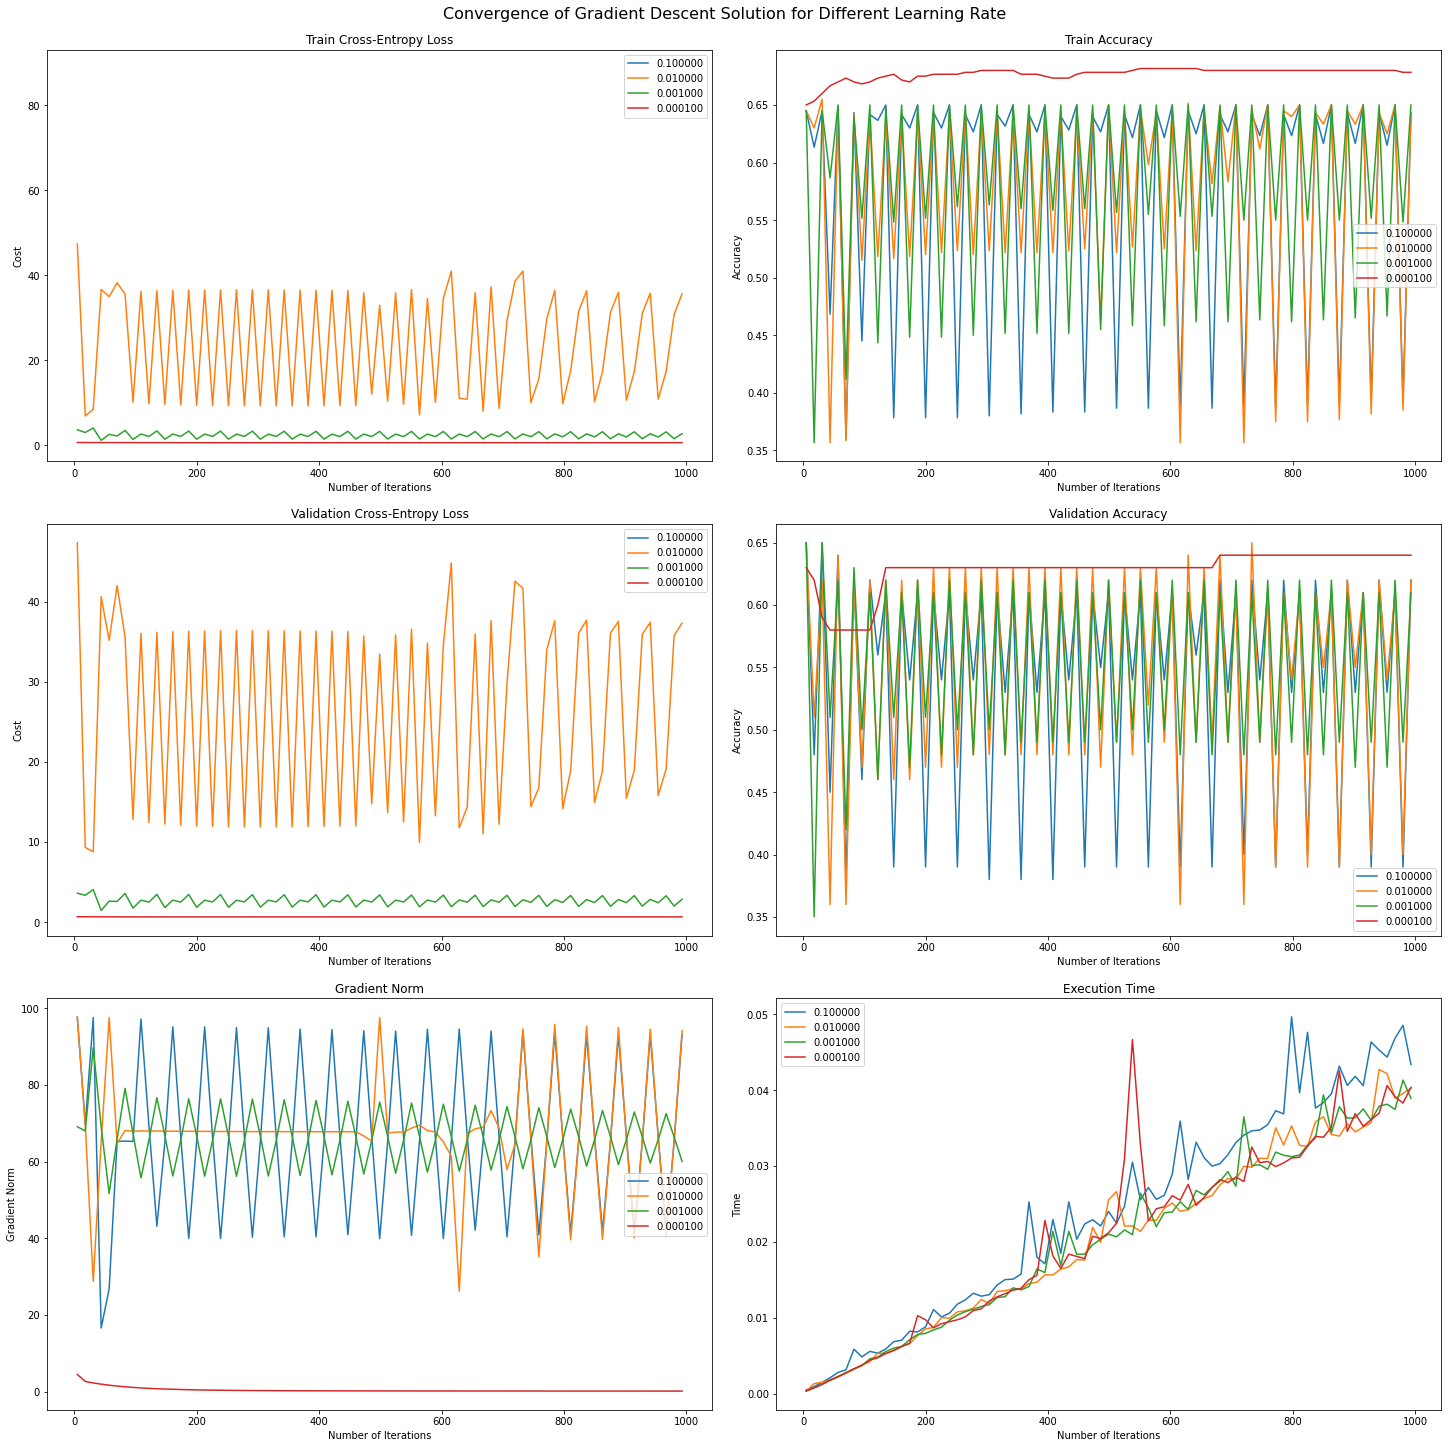

Minimal train cost: 0.6141781758288682
Learning Rate: 0.0001
Number of iterations: 993

Minimal validation cost: 0.6580093956224722
Learning Rate: 0.0001
Number of iterations: 161

Maximal train accuracy: 0.6816666666666666
Learning Rate: 0.0001
Number of iterations: 551

Maximal validation accuracy: 0.65
Learning Rate: 0.1
Number of iterations: 5



In [23]:
lr_range = np.array([0.1,0.01,0.001, 0.0001])
max_iters_range = np.arange(5,1000,13)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

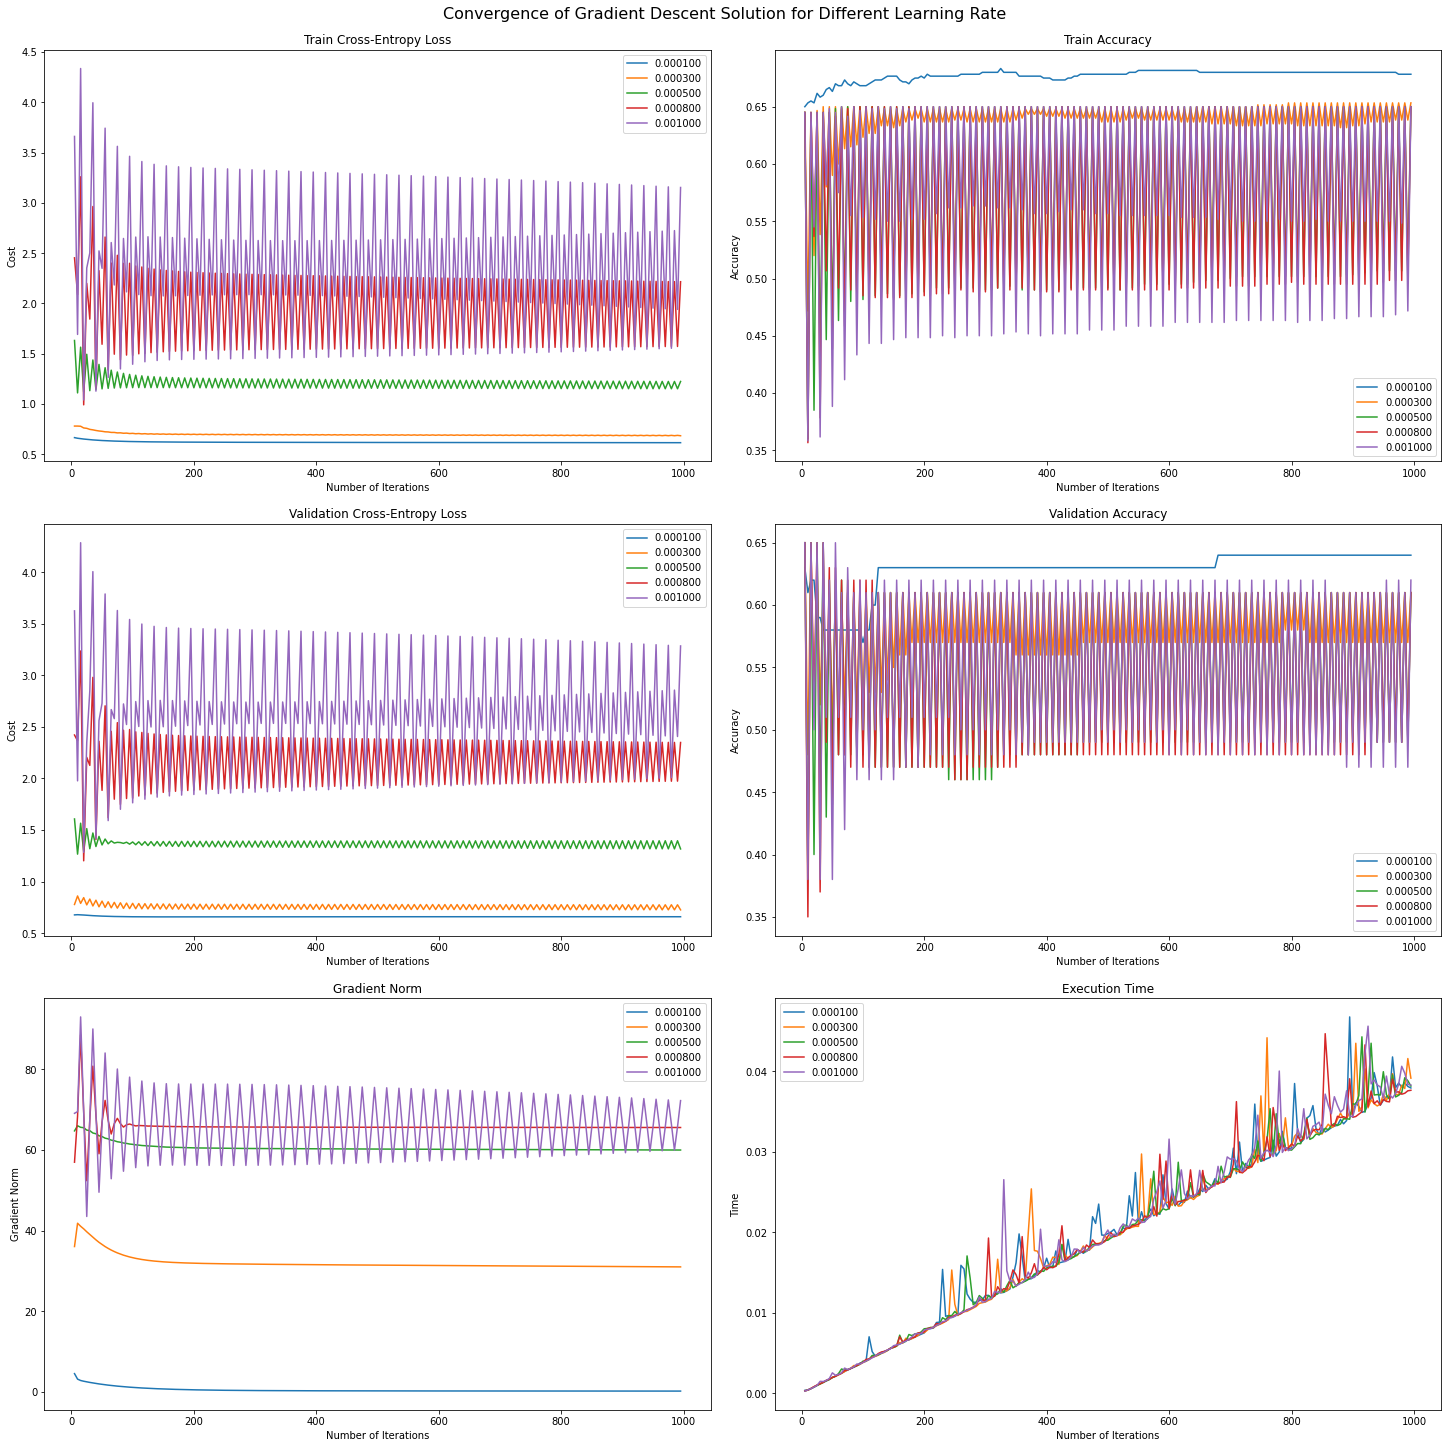

Minimal train cost: 0.6141708362066902
Learning Rate: 0.0001
Number of iterations: 995

Minimal validation cost: 0.6580063027306937
Learning Rate: 0.0001
Number of iterations: 165

Maximal train accuracy: 0.6833333333333333
Learning Rate: 0.0001
Number of iterations: 325

Maximal validation accuracy: 0.65
Learning Rate: 0.0003
Number of iterations: 5



In [24]:
lr_range = np.array([0.0001,0.0003, 0.0005, 0.0008, 0.001])
max_iters_range = np.arange(5,1000,5)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

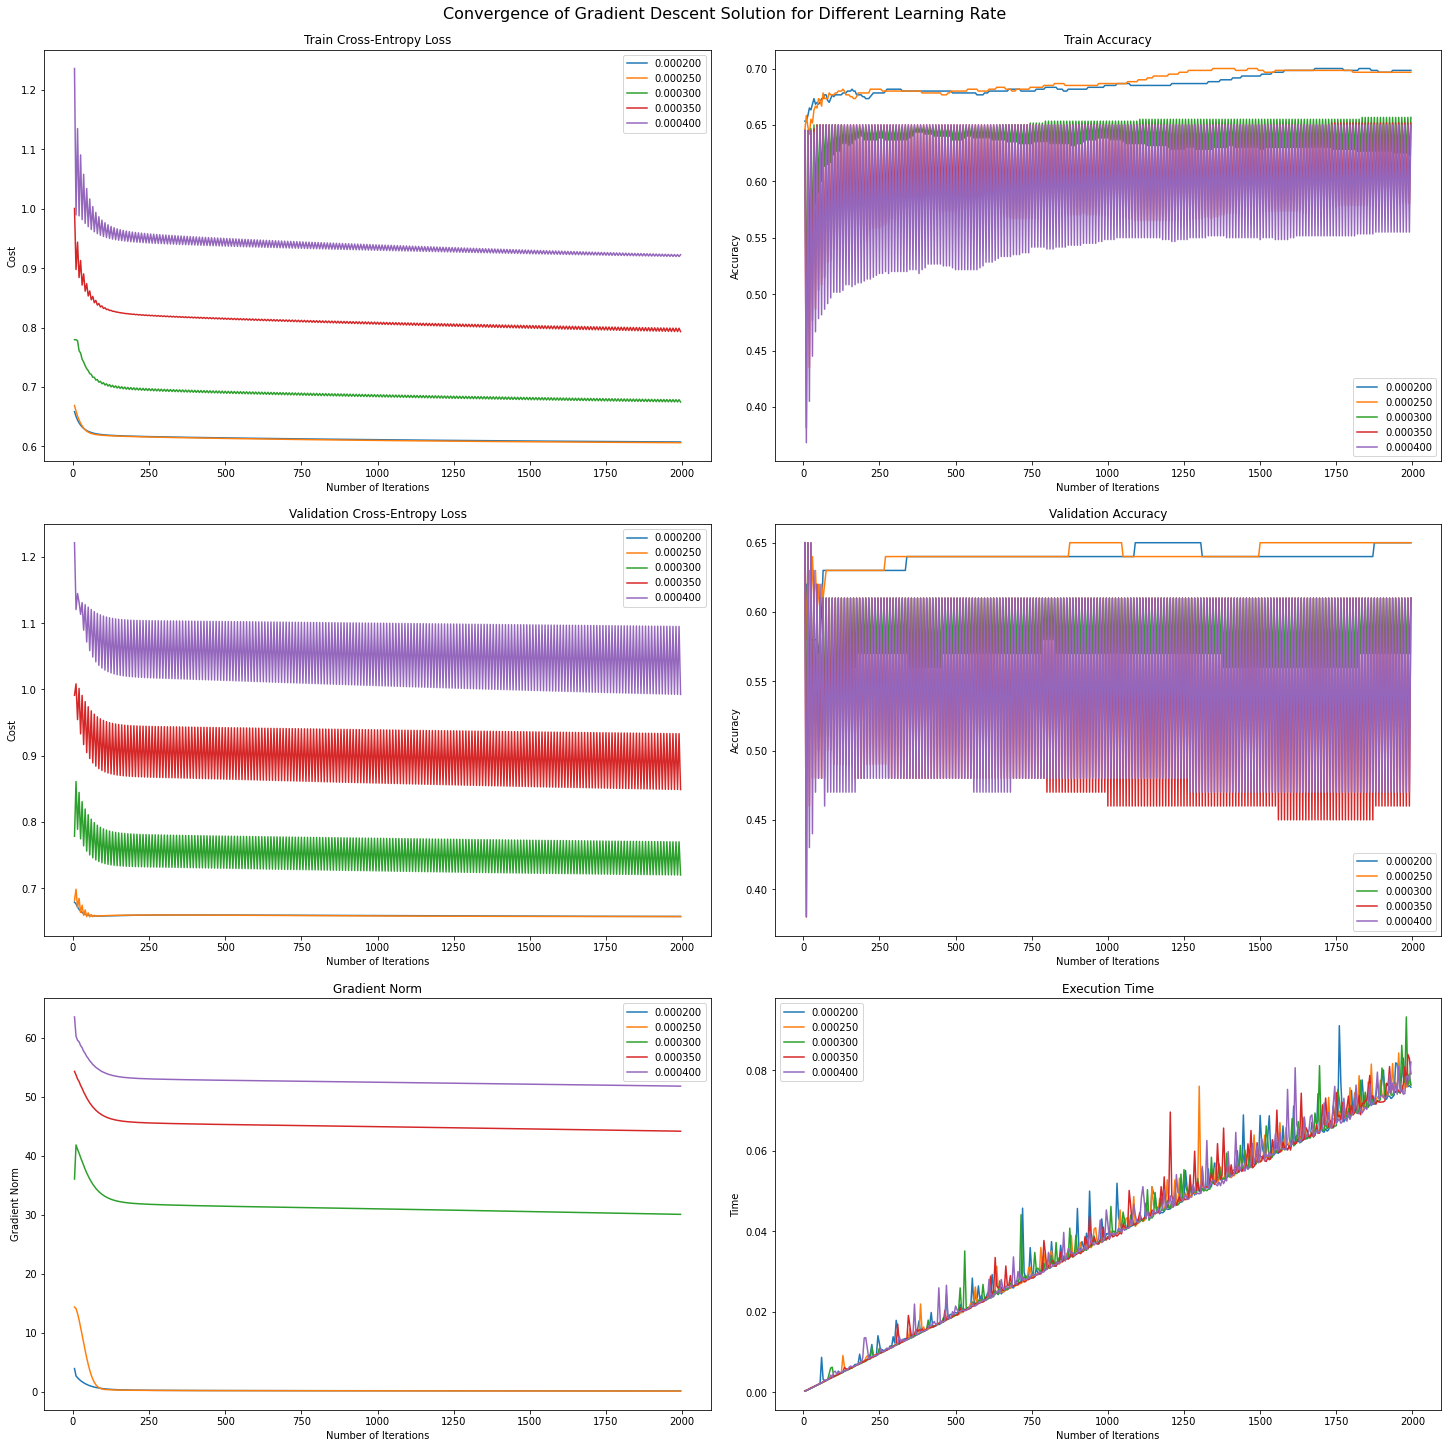

Minimal train cost: 0.6061068976145808
Learning Rate: 0.00025
Number of iterations: 1995

Minimal validation cost: 0.6567508292236195
Learning Rate: 0.00025
Number of iterations: 55

Maximal train accuracy: 0.7
Learning Rate: 0.0002
Number of iterations: 1680

Maximal validation accuracy: 0.65
Learning Rate: 0.0002
Number of iterations: 1090



In [29]:
lr_range = np.array([0.0002, 0.00025, 0.0003, 0.00035, 0.0004])
max_iters_range = np.arange(5,2000,5)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

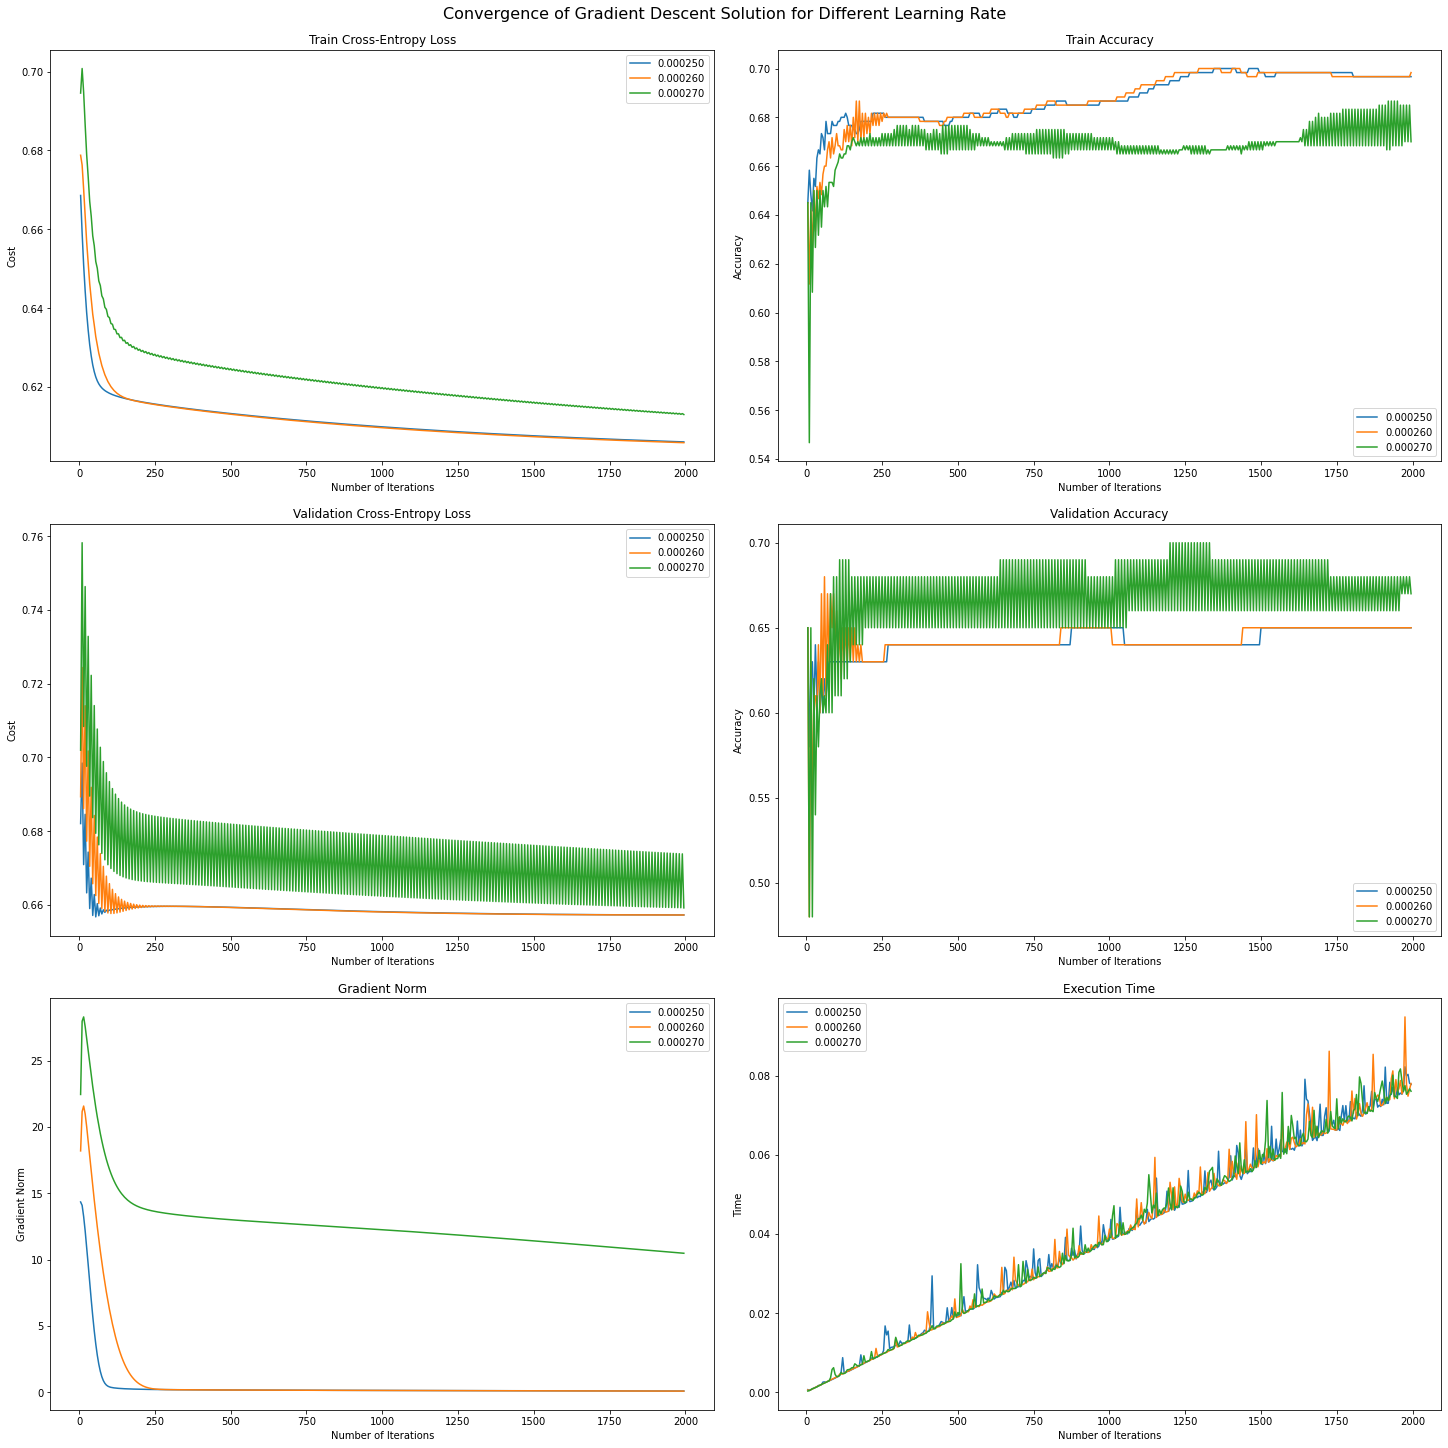

Minimal train cost: 0.6059064853340953
Learning Rate: 0.00026
Number of iterations: 1995

Minimal validation cost: 0.6567508292236195
Learning Rate: 0.00025
Number of iterations: 55

Maximal train accuracy: 0.7
Learning Rate: 0.00025
Number of iterations: 1345

Maximal validation accuracy: 0.7
Learning Rate: 0.00027
Number of iterations: 1200



In [30]:
lr_range = np.array([0.00025,0.00026, 0.00027])
max_iters_range = np.arange(5,2000,5)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

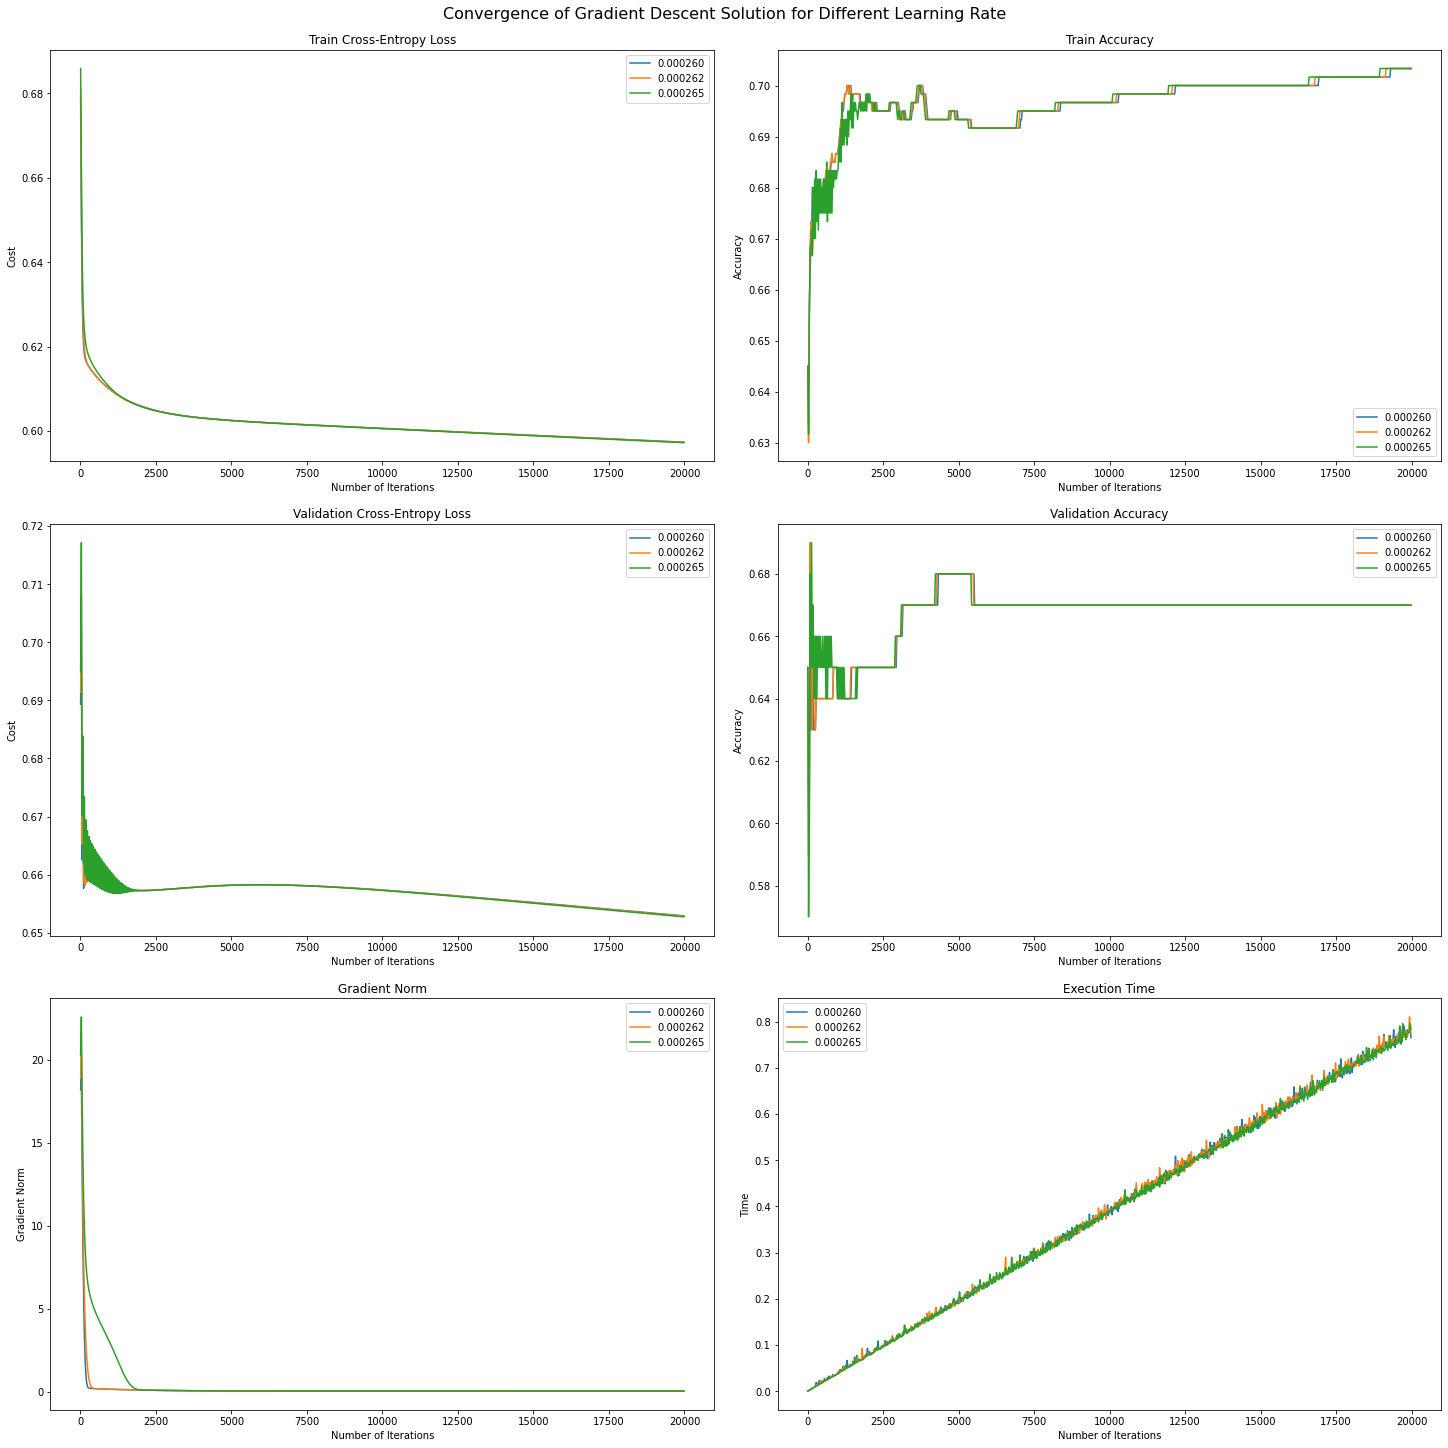

Minimal train cost: 0.5972107688484778
Learning Rate: 0.000265
Number of iterations: 19980

Minimal validation cost: 0.6527365021183114
Learning Rate: 0.000265
Number of iterations: 19980

Maximal train accuracy: 0.7033333333333334
Learning Rate: 0.00026
Number of iterations: 19305

Maximal validation accuracy: 0.69
Learning Rate: 0.000262
Number of iterations: 80



In [52]:
lr_range = np.array([0.00026,.000262, 0.000265])
max_iters_range = np.arange(5,20000,25)
epsilon=0.01
gd_hypertuning_plots(param_range_type='lr', param_range=lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, stochastic=False, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

terminated after 25000 iterations, with norm of the gradient equal to 0.034948850994873056
the weight found: [ 0.13194683  0.01402358 -0.03018073 -0.00108102  0.0015361  -0.00353409
  0.04448468 -0.01190091 -0.23219139]
terminated after 50000 iterations, with norm of the gradient equal to 0.033702499666005734
the weight found: [ 0.13114525  0.01451459 -0.02936854 -0.00121883  0.00147076 -0.00129998
  0.08541315 -0.01123741 -0.4558409 ]
terminated after 100000 iterations, with norm of the gradient equal to 0.03135048441021386
the weight found: [ 0.12980519  0.01548715 -0.02789876 -0.00145373  0.0013495   0.00298545
  0.15504897 -0.00995367 -0.88090886]
terminated after 200000 iterations, with norm of the gradient equal to 0.027174730491665685
the weight found: [ 1.28046908e-01  1.73604184e-02 -2.54834626e-02 -1.79430117e-03
  1.13775439e-03  1.08485417e-02  2.58736864e-01 -7.59956077e-03
 -1.64780307e+00]
terminated after 500000 iterations, with norm of the gradient equal to 0.018176898

<function matplotlib.pyplot.show>

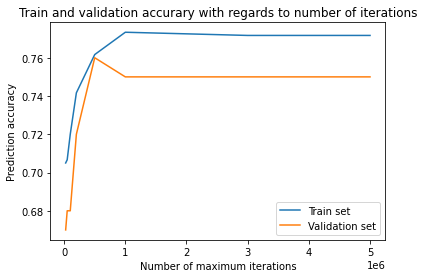

In [68]:
lr = 0.000265
epsilon = 0.01
max_iters_range = [25000, 50000, 100000, 200000, 500000, 1000000, 3000000, 5000000]
acc_train_array = np.zeros(len(max_iters_range))
acc_val_array = np.zeros(len(max_iters_range))

for i in range(0,len(max_iters_range)):

  #train model
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters_range[i], verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=False, batch_size=1)
  reg.fit(x_train, y_train)

  #compute error
  yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
  y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
  acc_train, acc_val = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val)

  #populate accuracy arrays
  acc_train_array[i] = acc_train
  acc_val_array[i] = acc_val
  
#Plot validation set and train set accuracy with regards to number of iteration (learning rate = 0.000265)
plt.title("Train and validation accurary with regards to number of iterations")
plt.plot(max_iters_range, acc_train_array, label="Train set")
plt.plot(max_iters_range, acc_val_array, label="Validation set")
plt.legend()
plt.xlabel("Number of maximum iterations")
plt.ylabel("Prediction accuracy")
plt.show



We noticed that somewhere in between 25000 and 1000000 iterations, increasing the number of iterations only decreases validation set accuracy. We repeat the same experiments to find a more precise value of optimum number of iterations. 

In [ ]:
lr = 0.000265
epsilon = 0.01
max_iters_range = [25000, 50000, 100000, 200000, 500000, 1000000, 3000000, 5000000]
acc_train_array = np.zeros(len(max_iters_range))
acc_val_array = np.zeros(len(max_iters_range))

for i in range(0,len(max_iters_range)):

  #train model
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters_range[i], verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=False, batch_size=1)
  reg.fit(x_train, y_train)

  #compute error
  yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
  y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
  acc_train, acc_val = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val)

  #populate accuracy arrays
  acc_train_array[i] = acc_train
  acc_val_array[i] = acc_val
  
#Plot validation set and train set accuracy with regards to number of iteration (learning rate = 0.000265)
plt.title("Train and validation accurary with regards to number of iterations")
plt.plot(max_iters_range, acc_train_array, label="Train set")
plt.plot(max_iters_range, acc_val_array, label="Validation set")
plt.legend()
plt.xlabel("Number of maximum iterations")
plt.ylabel("Prediction accuracy")
plt.show

Again, we repeat with iterations ranging from 450000 to 750000. 

terminated after 450000 iterations, with norm of the gradient equal to 0.019370619753519877
the weight found: [ 1.27210084e-01  2.13906292e-02 -2.14874956e-02 -2.24177220e-03
  7.37614567e-04  2.69189770e-02  4.12730302e-01 -3.01546436e-03
 -3.16300967e+00]
terminated after 500000 iterations, with norm of the gradient equal to 0.018176898577685393
the weight found: [ 1.27404049e-01  2.20760250e-02 -2.09155055e-02 -2.29865564e-03
  6.74332322e-04  2.96182211e-02  4.34541530e-01 -2.29237154e-03
 -3.41067233e+00]
terminated after 550000 iterations, with norm of the gradient equal to 0.01708102323471038
the weight found: [ 1.27665591e-01  2.27238501e-02 -2.03956713e-02 -2.35016905e-03
  6.15466692e-04  3.21724850e-02  4.54630073e-01 -1.62189482e-03
 -3.64327074e+00]
terminated after 600000 iterations, with norm of the gradient equal to 0.016073635961635482
the weight found: [ 1.27979009e-01  2.33360388e-02 -1.99211608e-02 -2.39750431e-03
  5.60618303e-04  3.45916832e-02  4.73277265e-01 -9.

<function matplotlib.pyplot.show>

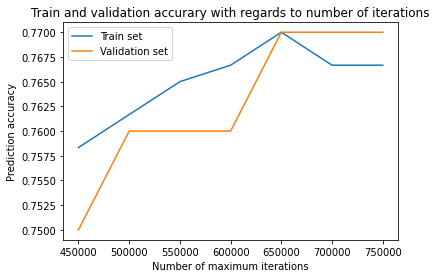

In [71]:
lr = 0.000265
epsilon = 0.01
max_iters_range = [450000, 500000, 550000, 600000, 650000, 700000, 750000]
acc_train_array = np.zeros(len(max_iters_range))
acc_val_array = np.zeros(len(max_iters_range))

for i in range(0,len(max_iters_range)):

  #train model
  reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters_range[i], verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=False, batch_size=1)
  reg.fit(x_train, y_train)

  #compute error
  yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
  y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
  acc_train, acc_val = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val)

  #populate accuracy arrays
  acc_train_array[i] = acc_train
  acc_val_array[i] = acc_val
  
#Plot validation set and train set accuracy with regards to number of iteration (learning rate = 0.000265)
plt.title("Train and validation accurary with regards to number of iterations")
plt.plot(max_iters_range, acc_train_array, label="Train set")
plt.plot(max_iters_range, acc_val_array, label="Validation set")
plt.legend()
plt.xlabel("Number of maximum iterations")
plt.ylabel("Prediction accuracy")
plt.show

#### **1.5 Results**

From the empirically testing, we decided to use a learning rate of 0.000265 and a maximum number of iterations of 650000. We set the convergence to the point where the gradient norm is smaller than 0.01.

In [72]:
lr = 0.000265
max_iters = 650000
epsilon = 0.01

reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True, momentum=False, momentum_coefficient=0.9, stochastic=False, batch_size=1)
reg.fit(x_train, y_train)

# compute error
yh_train, yh_val, yh_test = reg.predict(x_train), reg.predict(x_val), reg.predict(x_test)
y_pred_train, y_pred_val, y_pred_test = np.rint(yh_train), np.rint(yh_val), np.rint(yh_test)
acc_train, acc_val, acc_test = accuracy(y_train, y_pred_train), accuracy(y_val, y_pred_val), accuracy(y_test, y_pred_test)

print("train accuracy: {acc_train}".format(acc_train=acc_train))
print("validation accuracy: {acc_val}".format(acc_val=acc_val))
print("test accuracy: {acc_test}".format(acc_test=acc_test))

terminated after 650000 iterations, with norm of the gradient equal to 0.015146174267468145
the weight found: [ 1.28331425e-01  2.39146200e-02 -1.94862616e-02 -2.44153146e-03
  5.09428484e-04  3.68849768e-02  4.90695382e-01 -4.19841503e-04
 -4.06801535e+00]
train accuracy: 0.77
validation accuracy: 0.77
test accuracy: 0.7647058823529411


### **2. Mini-batch Stochastic Gradient Descent**

Implement mini-batch stochastic gradient descent. Then, using growing minibatch sizes (e.g. 8, 16, 32, ...) compare the convergence speed and the quality of the final solution to the fully batched baseline. What configuration works the best among the ones you tried ?

In [ ]:
batch_size_range = [8, 32, 128, 256, 512]
max_iters_range = np.arange(5,650000,1000)
epsilon=0.01
gd_hypertuning_plots(param_range_type='bs', param_range=batch_size_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.000265, stochastic=True, batch_size=1, momentum=False, momentum_coefficient=0.9, epsilon=epsilon)

On average, the biggest batch size 

### **3. Gradient Descent with Momentum**

Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the convergence speed and the quality of the final solution.


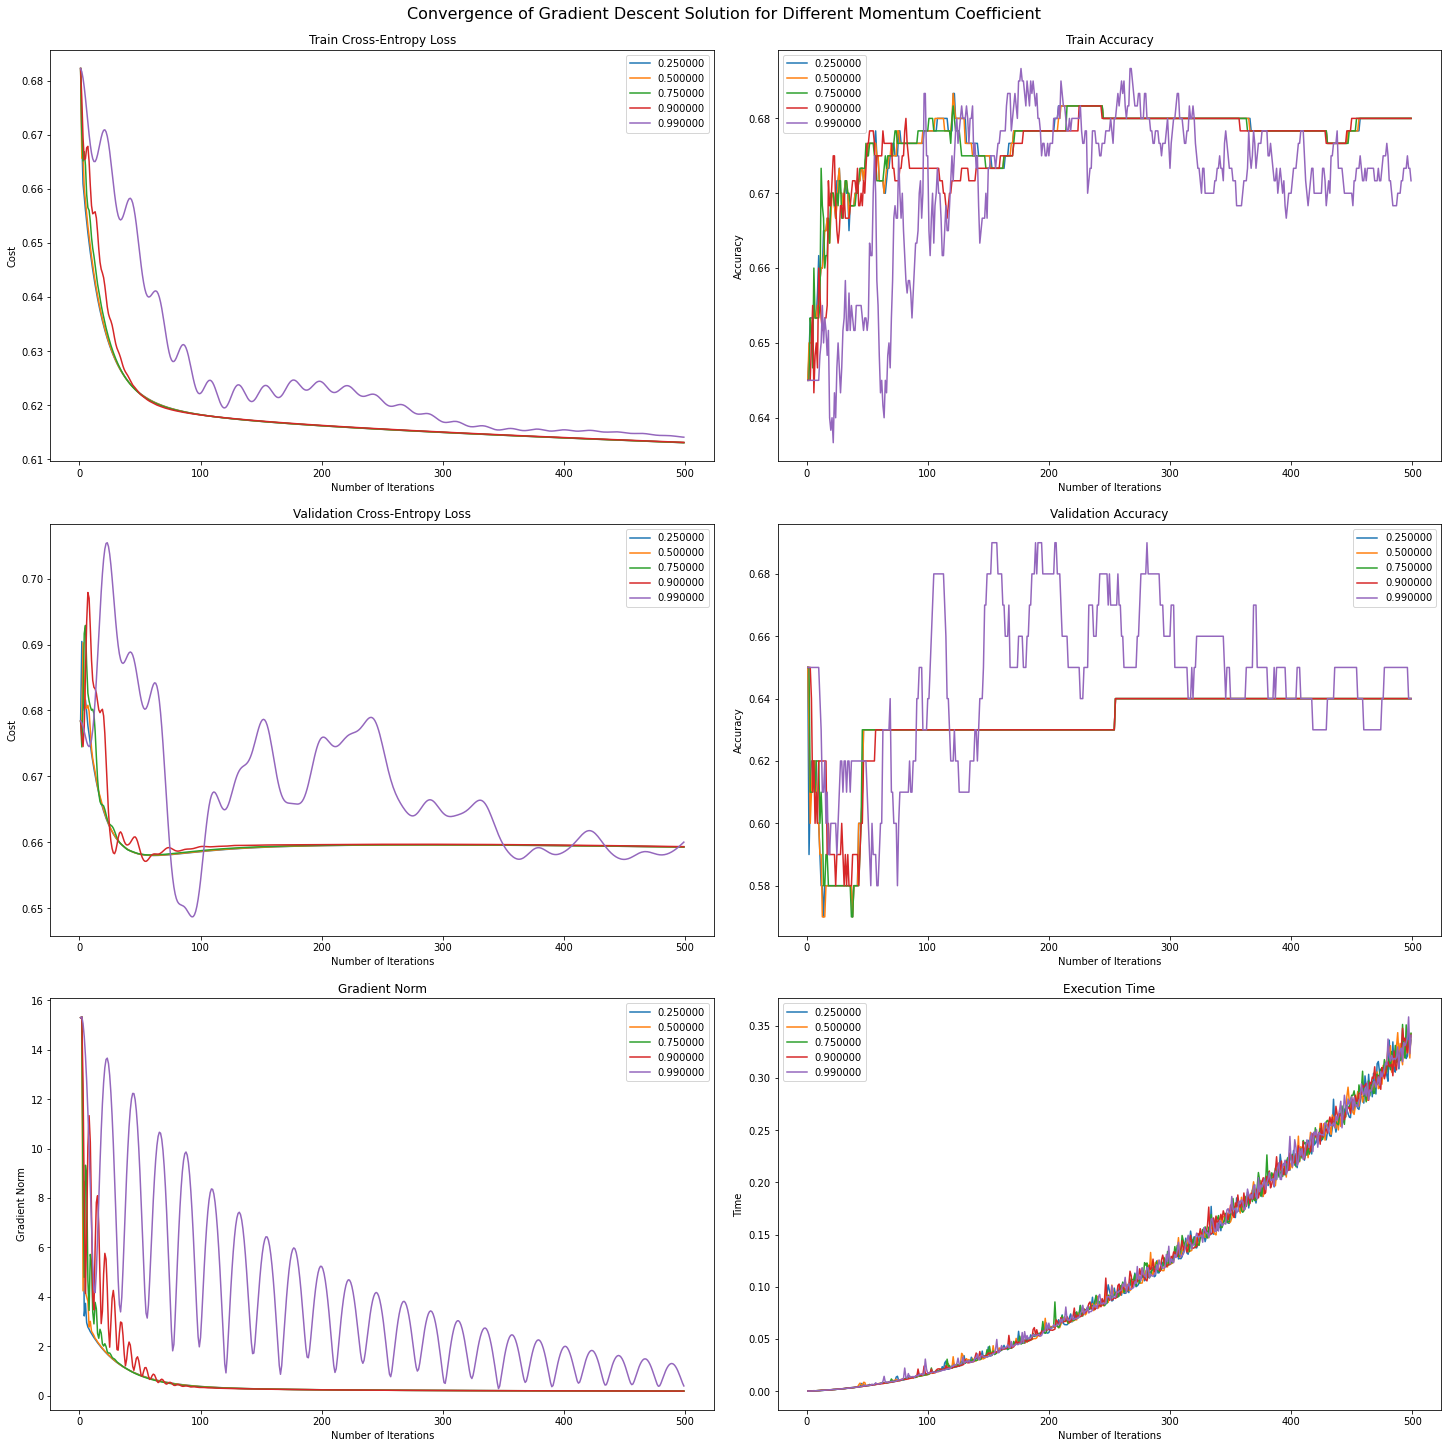

Minimal train cost: 0.6130520166394055
Momentum Coefficient: 0.25
Number of iterations: 499

Minimal validation cost: 0.6487077528482562
Momentum Coefficient: 0.99
Number of iterations: 93

Maximal train accuracy: 0.6866666666666666
Momentum Coefficient: 0.99
Number of iterations: 177

Maximal validation accuracy: 0.69
Momentum Coefficient: 0.99
Number of iterations: 153



In [76]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,500,1)
epsilon=0.01
gd_hypertuning_plots(param_range_type='mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.000265, stochastic=False, batch_size=1, momentum=True, momentum_coefficient=0.9, epsilon=epsilon)

### **4. Gradient Descent with Momentum using smallest and largest batch sizes from 2)**

Repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?


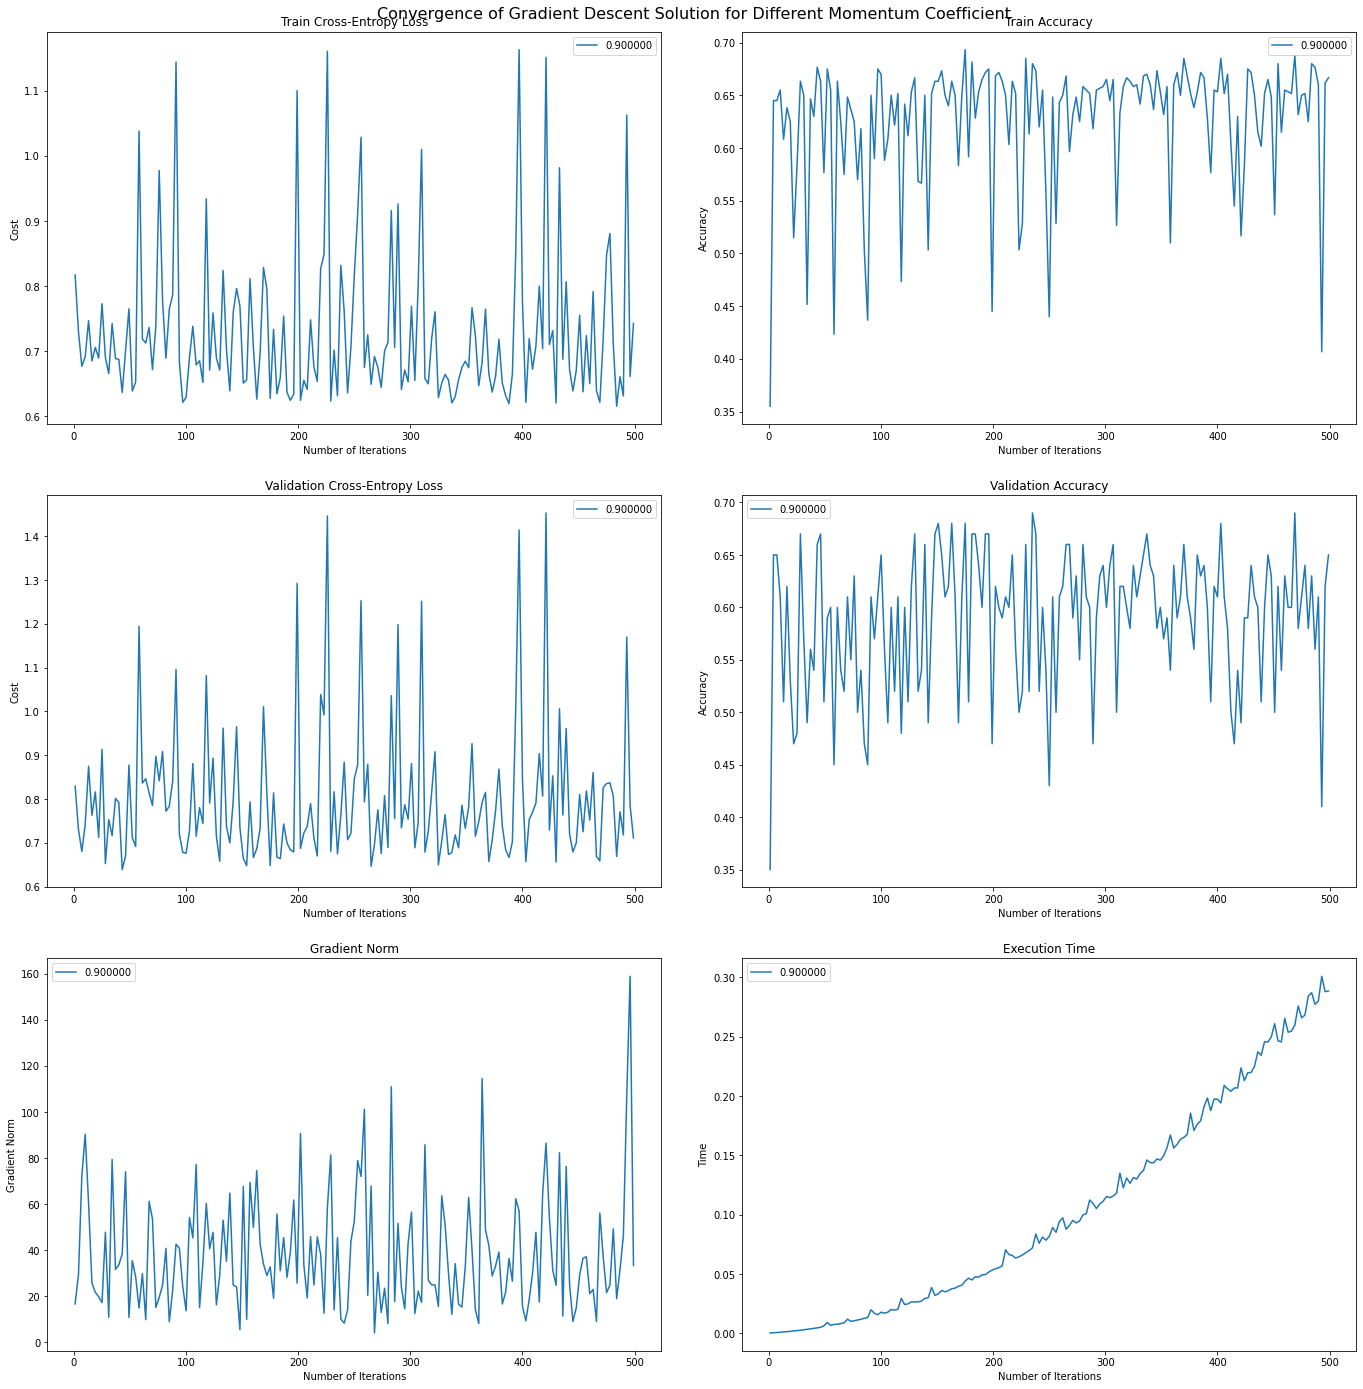

Minimal train cost: 0.6151949246883895
Momentum Coefficient: 0.9
Number of iterations: 484

Minimal validation cost: 0.6389331717046594
Momentum Coefficient: 0.9
Number of iterations: 43

Maximal train accuracy: 0.6933333333333334
Momentum Coefficient: 0.9
Number of iterations: 175

Maximal validation accuracy: 0.69
Momentum Coefficient: 0.9
Number of iterations: 235



In [ ]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,500,3)
epsilon=0.01
min_bs = 8
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.000265, stochastic=True, batch_size=min_bs, momentum=True, momentum_coefficient=0.9, epsilon=epsilon)

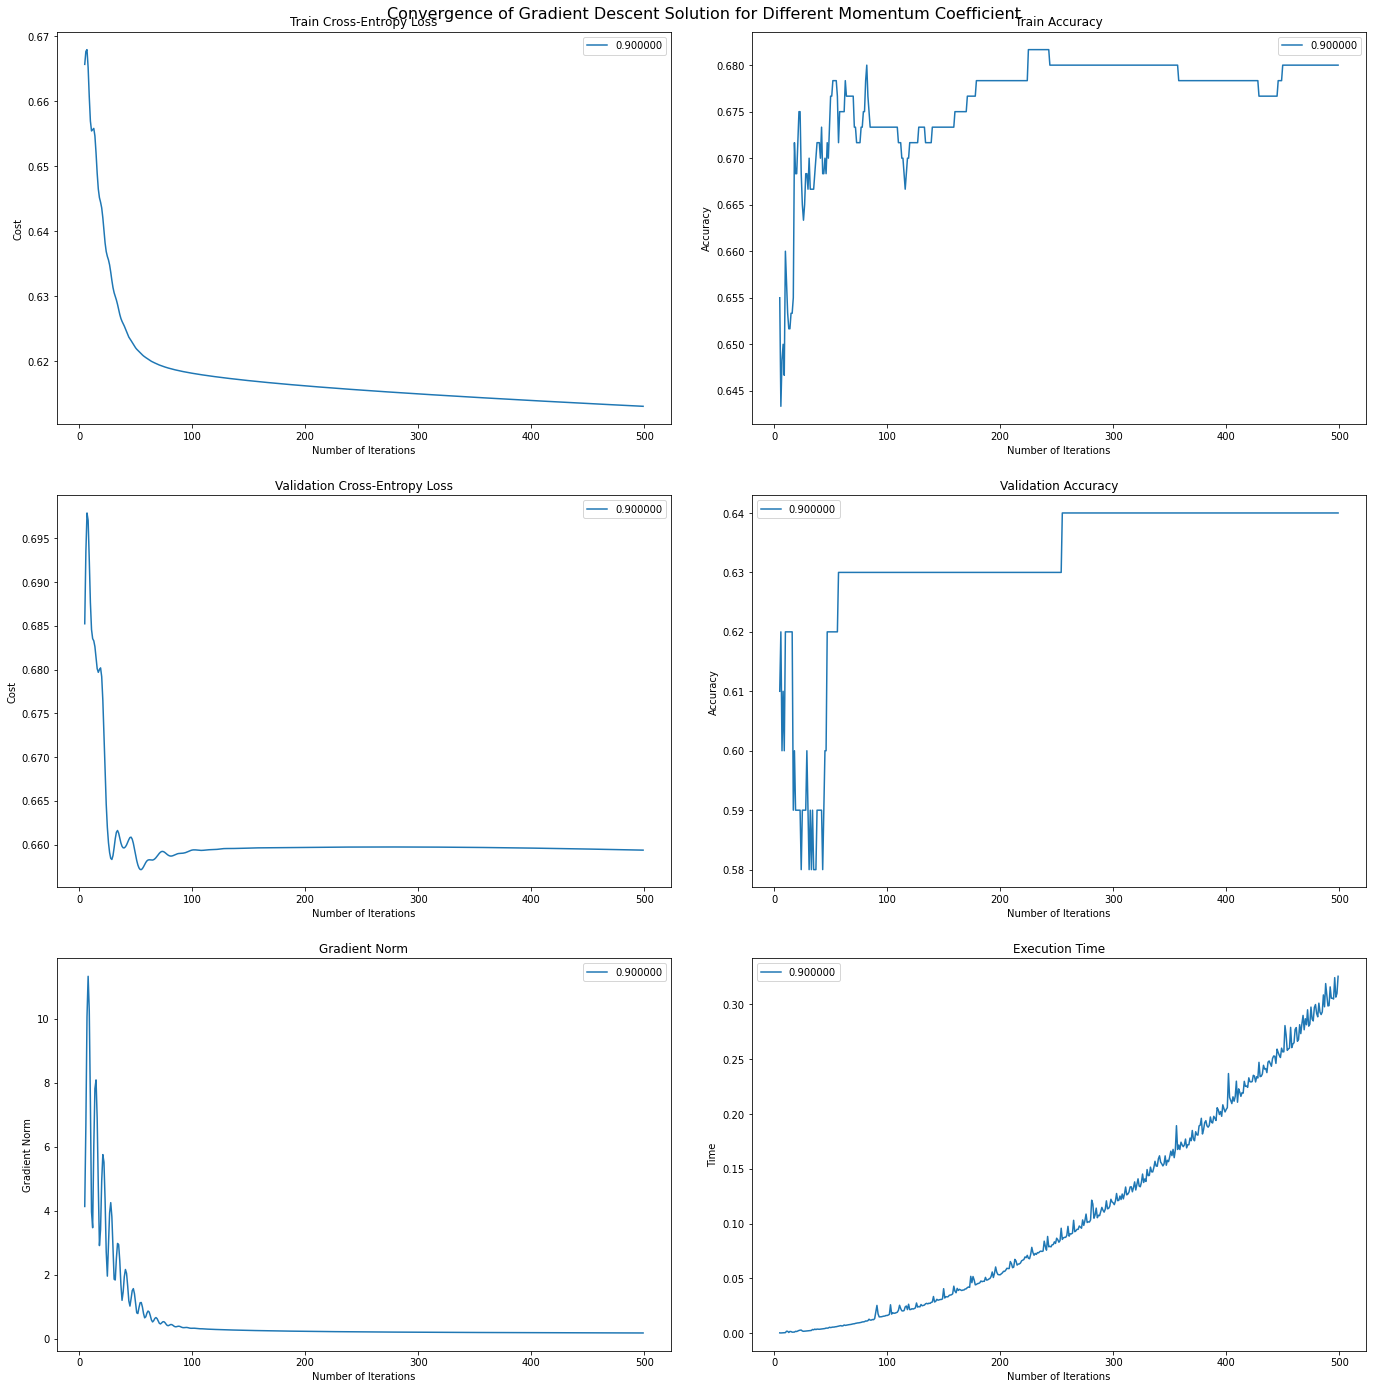

Minimal train cost: 0.6131090786212035
Momentum Coefficient: 0.9
Number of iterations: 499

Minimal validation cost: 0.65713086223868
Momentum Coefficient: 0.9
Number of iterations: 55

Maximal train accuracy: 0.6816666666666666
Momentum Coefficient: 0.9
Number of iterations: 225

Maximal validation accuracy: 0.64
Momentum Coefficient: 0.9
Number of iterations: 255



In [ ]:
momentum_coefficient_range = [0.25, 0.5, 0.75, 0.9, 0.99]
max_iters_range = np.arange(1,500,3)
max_bs = 512
epsilon=0.01
gd_hypertuning_plots(param_range_type ='mc', param_range=momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.000265, stochastic=False, batch_size=max_bs, momentum=True, epsilon=epsilon)

<hr><font color="green"><h1>from file: 2</h1></font>

## Part 2 : Text Classification

In [89]:
# All the used libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from textblob import Word
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import itertools

In [92]:
# Functions 
def plot_ROC_curve(fpr,tpr,auc):
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plotConfusionMatrix(prediction,y):
  conf = confusion_matrix(y, prediction)
  sns.heatmap(conf, annot=True)
  plt.show()

def train_model(parameters):
  print(parameters)
  pipe = Pipeline([('vect', CountVectorizer(stop_words=parameters["stopwords"], ngram_range = parameters["ngram_range"],
                                            tokenizer=word_tokenize)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegressionCV(solver=parameters["solver"]))])
                
  model = pipe.fit(x_train, y_train)
  prediction = model.predict(x_val)
  accuracy = round(accuracy_score(y_val, prediction)*100,2)
  print("accuracy: {}%".format(accuracy))
  fpr, tpr, _ = metrics.roc_curve(y_val,  prediction)
  auc = metrics.roc_auc_score(y_val, prediction)
  plot_ROC_curve(fpr,tpr,auc)
  plotConfusionMatrix(prediction=prediction,y=y_val)
  return accuracy

def find_best_model():

  best_acc = 0.0
  best_params = {}
  accuracies = []
  nltk.download('punkt')

  ranges = [(1,1),(1,2),(2,2)]
  stops = [None, 'english']

  for range,stopword in itertools.product(ranges,stops):
    params = {
        "ngram_range": range,
        "solver": 'liblinear',
        "stopwords": stopword
    }
    acc = train_model(parameters=params)
    accuracies.append(acc)
    if acc > best_acc:
      best_acc = acc
      best_params = params

  print("Best accuracy: {}% for {}% ".format(best_acc,best_params)) 
  return best_params, accuracies
  
def expandContractions(text,contractions_dict=contractions_dict):
    regex=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return regex.sub(replace, text)

def stemSentence(sentence,stemmer):
  if stemmer == 'porter':
    stm = PorterStemmer()
  elif stemmer == 'snowball':
    stm = SnowballStemmer('english')
  elif stemmer == 'lancaster':
    stm = LancasterStemmer()    
  token_words=word_tokenize(sentence)
  stem_sentence=[]
  for word in token_words:
    stem_sentence.append(stm.stem(word))
    stem_sentence.append(" ")
  return "".join(stem_sentence)      

##Loading the data sets

In [93]:
# Loading Datasets

# Fake_News_Train

news_train_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_train.csv'
news_train_df = pd.read_csv(news_train_url)
display(news_train_df)

# Fake_News_Val

news_val_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_val.csv'
news_val_df = pd.read_csv(news_val_url)
display(news_val_df)

# Fake_News_Test

news_test_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_test.csv'
news_test_df = pd.read_csv(news_test_url)
display(news_test_df)

,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
19995,"Warning: small, petty spoilers for the Game of...",1
19996,Shilpa Shetty will soon make her Bollywood deb...,0
19997,Add a digital black hole image to the Allstate...,0
19998,Share\nThe name W. L. Gore & Associates might ...,1


,text,label
0,When don't you have something appropriate to w...,0
1,Share this article with Google Plus\nA brief g...,0
2,NEW YORK — Yankees beat reporter Brendan Kuty ...,1
3,The Goonies has always posed challenges for fi...,0
4,"Parisians sang, lit candles and prayed to pay ...",1
...,...,...
1995,"KABUL - In past several weeks, hectic negotiat...",1
1996,1) Where is Wan-Bissaka in the young player sh...,1
1997,It may seem counterintuitive that Calgary shou...,0
1998,The CEOs of America's biggest banks were summo...,1


,text,label
0,Is it possible the President’s pressure campai...,0
1,Pennsylvania is the place to go for farmers ma...,1
2,While he is frantically putting together a pro...,0
3,"The one-man industry, Yasir Akhtar, is all set...",1
4,"All Parties Sanctions Group, Business Leaders,...",0
...,...,...
2995,Chennai: The proposed merger of Dena Bank and ...,0
2996,Netflix plans to buy a portion of Egyptian cin...,0
2997,About three months ago we had reported that Ta...,1
2998,The fight against HIV/AIDS and tuberculosis sh...,0


##Perform basic data cleaning 

In [94]:
# Data Cleaning
news_train_df.dropna(inplace=True)
news_train_df.drop_duplicates(inplace=True)
news_val_df.dropna(inplace=True)
news_val_df.drop_duplicates(inplace=True)

##Data Preprocessing 


1.   Expanding Contractions
2.   Converting all words to lower-case
3.   Removing punctuations
4.   Removing extra spaces
5.   Stemming the words

Notes about stemming: We compared the performance of three stemmers namely Porter, SnowBall, and Lancaster. Based on their documentations here is some background about them:

Porter is the most commonly used stemmer. Snowball is an improvement over porter. It is slightly faster computation time than porter, with a reasonably large community around it. Lancaster is a very aggressive stemming algorithm. The fastest algorithm here, and will reduce the working set of words hugely.


In [95]:
# Data Preprocessing

# Part 1: Handling Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [96]:
# Function for expanding the extractions in news'values

news_train_df['text'] = news_train_df['text'].apply(lambda x:expandContractions(x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:expandContractions(x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:expandContractions(x))   

# Pre-Processing Part 2 : Lower Case 
news_train_df['text'] = news_train_df['text'].apply(lambda x:x.lower())
news_val_df['text'] = news_val_df['text'].apply(lambda x:x.lower())
news_test_df['text'] = news_test_df['text'].apply(lambda x:x.lower())

# Pre-Processing Part 3 : Removing Punctuatoins
news_train_df['text'] = news_train_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))  

# Pre-Processing Part 4 : Removing Extra Spaces
news_train_df['text'] = news_train_df['text'].apply(lambda x:re.sub(' +',' ',x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:re.sub(' +',' ',x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:re.sub(' +',' ',x))

# Pre-Processing Part 5 : Stemming
# NOTE: If you want to perform stemming with other type of stemmer, change the input of stemSentence() below!
nltk.download('punkt')
news_train_df['text'] = news_train_df['text'].apply(lambda x:stemSentence(x,'lancaster'))
news_val_df['text'] = news_val_df['text'].apply(lambda x:stemSentence(x,'lancaster'))
news_test_df['text'] = news_test_df['text'].apply(lambda x:stemSentence(x,'lancaster'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Looking at data through some visualizations

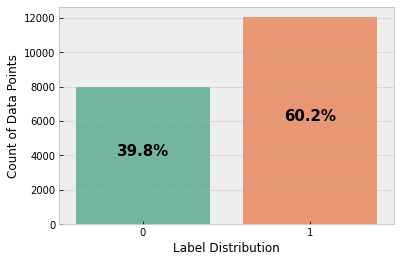

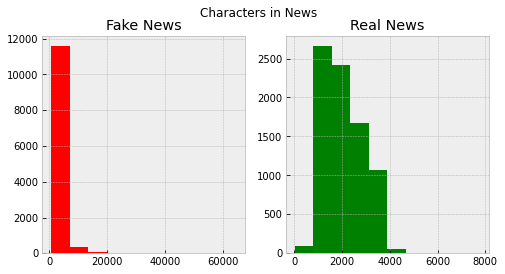

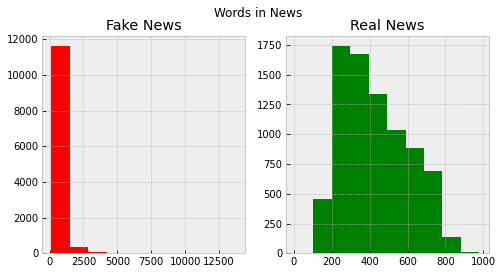

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


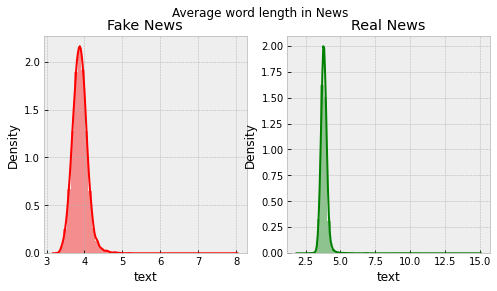

In [97]:
# Analyzing some features in the original data 
# The default visualizations are after lancaster stemming. You can change ththe stemmer in the above cell!
plt.style.use('bmh')

axis=sns.countplot(x="label",palette='Set2',data=news_train_df)
for patch in axis.patches:
    axis.text(x = patch.get_x() + patch.get_width()/2, y = patch.get_height()/2,
    s = f"{np.round(patch.get_height()/len(news_train_df)*100, 1)}%",
    ha = 'center', size = 15, weight = 'bold',color = 'black')
plt.xlabel("Label Distribution", size=12)
plt.ylabel('Count of Data Points', size=12)
plt.show()

fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

news_len = news_train_df[news_train_df['label']==1]['text'].str.len()
ax1.hist(news_len,color='red')
ax1.set_title("Fake News")

news_len = news_train_df[news_train_df['label']==0]['text'].str.len()
ax2.hist(news_len,color='green')
ax2.set_title("Real News")

fig.suptitle("Characters in News")
plt.show()

fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

news_len = news_train_df[news_train_df['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(news_len,color='red')
ax1.set_title("Fake News")

news_len = news_train_df[news_train_df['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(news_len,color='green')
ax2.set_title("Real News")

fig.suptitle("Words in News")
plt.show()

# Average word_length in fake/real news
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

word_len = news_train_df[news_train_df['label']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_len.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title("Fake News")

word_len = news_train_df[news_train_df['label']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_len.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title("Real News")

fig.suptitle("Average word length in News")
plt.show()

In [98]:
# Defining X_train and Y_train based on the news_train_df
y_train = news_train_df['label']
x_train = news_train_df['text']
x_test = news_test_df['text']
y_test = news_test_df['label']
x_val = news_val_df['text']
y_val = news_val_df['label']

##Finding the best hyper-parameters by testing on validation data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'ngram_range': (1, 1), 'solver': 'liblinear', 'stopwords': None}
accuracy: 76.2%


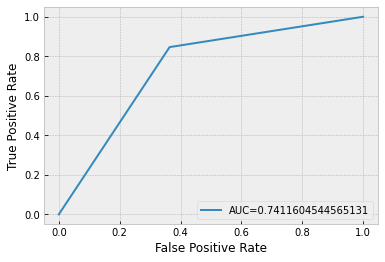

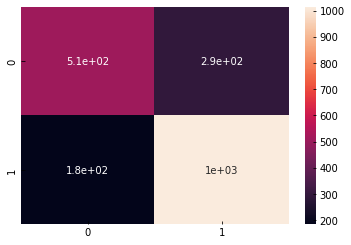

{'ngram_range': (1, 1), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 71.7%


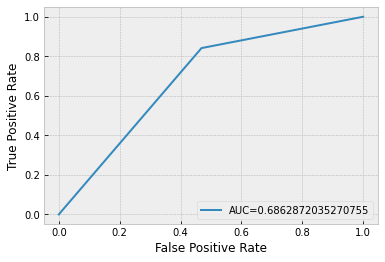

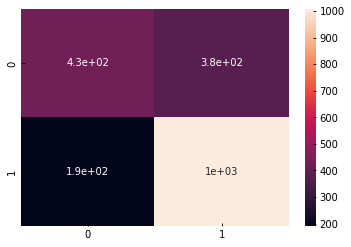

{'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': None}
accuracy: 78.15%


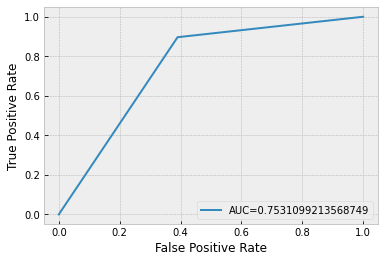

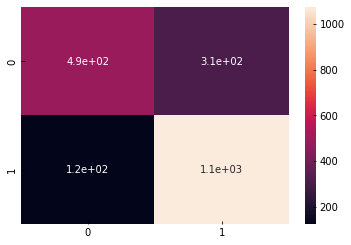

{'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 73.95%


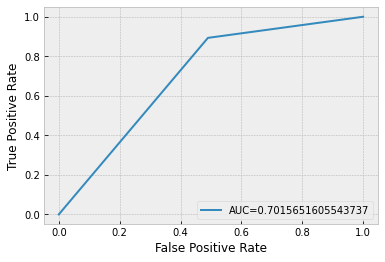

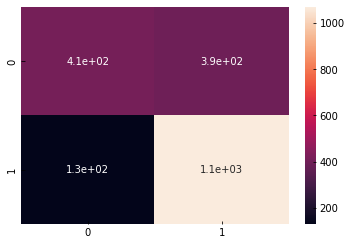

{'ngram_range': (2, 2), 'solver': 'liblinear', 'stopwords': None}
accuracy: 73.9%


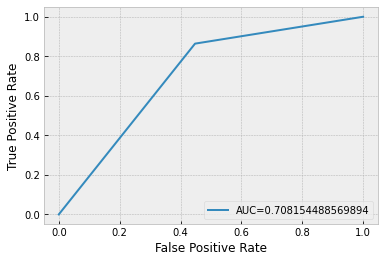

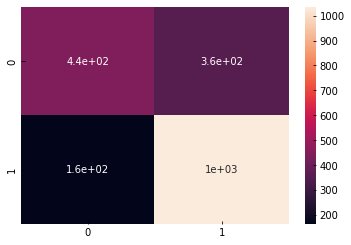

{'ngram_range': (2, 2), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 70.35%


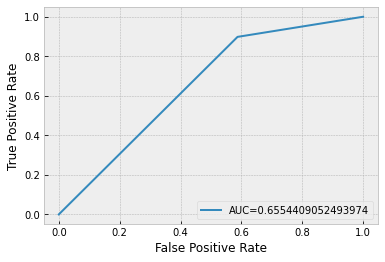

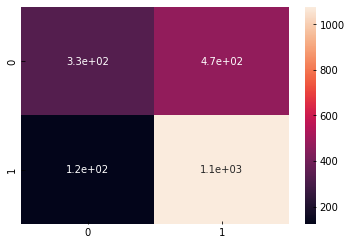

Best accuracy: 78.15% for {'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': None}% 


In [73]:
# Finding the best model on validation set 
best_model_params, training_accuracies = find_best_model()

## Comapring three stemmers's performance on validation data set

[76.2, 71.7, 78.15, 73.95, 73.9, 70.35]


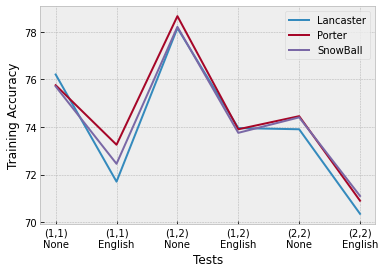

In [81]:
print(training_accuracies)
porter = [75.75, 73.25, 78.65, 73.9, 74.45, 70.9]
snowball = [75.7, 72.45, 78.2, 73.75, 74.4, 71.1]
x= [1,2,3,4,5,6] 
xticks=['(1,1)\nNone','(1,1)\nEnglish','(1,2)\nNone','(1,2)\nEnglish','(2,2)\nNone','(2,2)\nEnglish']
plt.plot(x, training_accuracies, label = "Lancaster")
plt.plot(x, porter, label = "Porter")
plt.plot(x, snowball, label = "SnowBall")
plt.xticks(x,xticks)
plt.xlabel('Parameters')
# Set the y axis label of the current axis.
plt.ylabel('Training Accuracy')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

## Fitting the test data into the best pipeline and reporting the results 

accuracy: 78.37%
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      1230
           1       0.78      0.89      0.83      1770

    accuracy                           0.78      3000
   macro avg       0.79      0.76      0.77      3000
weighted avg       0.79      0.78      0.78      3000



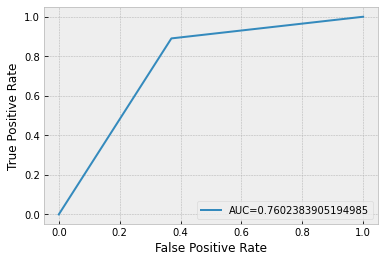

3000


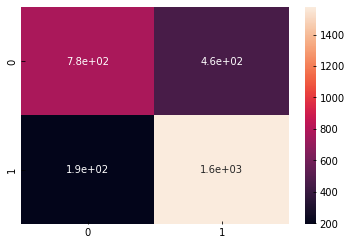

In [99]:
pipe = Pipeline([('vect', CountVectorizer(stop_words=best_model_params['stopwords'], ngram_range = best_model_params["ngram_range"], 
                                          tokenizer=word_tokenize)),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegressionCV(solver=best_model_params["solver"]))])
                
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
accuracy = round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(accuracy))
print(classification_report(y_test, prediction))
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction)
auc = metrics.roc_auc_score(y_test, prediction)
plot_ROC_curve(fpr,tpr,auc)
print(len(prediction))
plotConfusionMatrix(prediction=prediction,y=y_test)

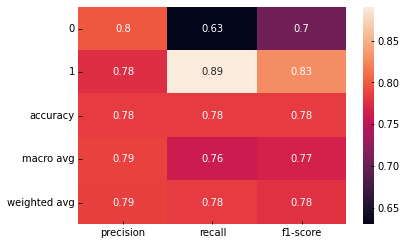

In [83]:
clf_report = classification_report(y_test, prediction,output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True) 